## Logistic Regression Model Using Lumbar Coordinate Metadata

This project trains and evaluates a **multiclass Logistic Regression model** using exclusively the metadata provided in the `coords_rsna_improved.csv` file from the *Lumbar Coordinate Pretraining Dataset* by Brendan Artley (Kaggle).

The notebook focuses on working **only with structured CSV data**, without requiring the associated medical images. The dataset contains coordinate annotations (e.g., `relative_x`, `relative_y`), instance and study identifiers, anatomical levels, laterality information, and diagnostic labels describing different types of spinal canal or foraminal narrowing.

### Objectives

- Load and preprocess the CSV file (handle missing values, select relevant features).
- Encode categorical and numerical features through a clean preprocessing pipeline.
- Train a **multinomial Logistic Regression classifier** to predict the `condition` label.
- Apply a stratified 70/15/15 train–validation–test split to preserve class distribution.
- Address class imbalance via `class_weight='balanced'`.
- Evaluate the model using:
  - Accuracy on validation and test sets  
  - Per-class precision, recall, and F1-score  
  - Confusion matrix  

### Why Logistic Regression?

Although more complex models (CNNs, transformers, etc.) can be applied to medical imaging tasks, Logistic Regression provides:

- A transparent, interpretable baseline  
- A fast training cycle  
- A good reference point for future comparison with deep learning approaches  
- A way to assess how much predictive power comes from metadata alone  

### Dataset Notes

- The dataset includes **five medical diagnostic categories** related to lumbar spine pathology.
- The CSV includes both **numeric features** (relative coordinates, instance number) and **categorical features** (side, spine level).
- These features allow building a structured ML model without accessing DICOM or JPG images.
- Labels are moderately imbalanced; therefore, class-weighting is used during training.

### Deliverables

This notebook will produce:
- A fully trained Logistic Regression pipeline  
- Metrics and evaluation plots  
- A reusable `.joblib` model (optional)  
- A reproducible workflow suitable for experimentation or baseline benchmarking  

In [2]:
# Imports (comments in English)
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Optional plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import kagglehub
import shutil
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw"
DATA_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR

cached_path = Path(kagglehub.dataset_download("brendanartley/lumbar-coordinate-pretraining-dataset"))

target_dir = DATA_DIR / "lumbar-coordinate-pretraining-dataset"
target_dir.mkdir(parents=True, exist_ok=True)

shutil.copytree(cached_path, target_dir, dirs_exist_ok=True)

print("Dataset stored at:", target_dir)

KAG_CSV_CANDIDATES = ["coords_rsna_improved.csv", "coords_pretrain.csv"]


Dataset stored at: C:\Users\mmich\Documentos\Maestría en Sistemas Computacionales\3er Semestre\Aprendizaje Automatico\iteso ML\iteso_class\data\raw\lumbar-coordinate-pretraining-dataset


In [3]:

# Desktop path
CSV_PATH = target_dir / KAG_CSV_CANDIDATES[0]

# Validate path
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(
        f"CSV_PATH does not exist:\n{CSV_PATH}\n"
        "Please update the path if running on another machine."
    )

print(f"[INFO] Loading CSV from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

print("[INFO] CSV loaded successfully.")
print("[INFO] Columns:", list(df.columns))

display(df.head(5))



[INFO] Loading CSV from: C:\Users\mmich\Documentos\Maestría en Sistemas Computacionales\3er Semestre\Aprendizaje Automatico\iteso ML\iteso_class\data\raw\lumbar-coordinate-pretraining-dataset\coords_rsna_improved.csv
[INFO] CSV loaded successfully.
[INFO] Columns: ['Unnamed: 0', 'series_id', 'relative_x', 'relative_y', 'condition', 'side', 'instance_number', 'study_id', 'level']


,Unnamed: 0,series_id,relative_x,relative_y,condition,side,instance_number,study_id,level
0,0,10996,0.521148,0.325282,Left Neural Foraminal Narrowing,L,13,3996069892,L1/L2
1,1,10996,0.516856,0.319701,Right Neural Foraminal Narrowing,R,6,3996069892,L1/L2
2,2,10996,0.493773,0.400966,Left Neural Foraminal Narrowing,L,12,3996069892,L2/L3
3,3,10996,0.504032,0.385531,Right Neural Foraminal Narrowing,R,6,3996069892,L2/L3
4,4,10996,0.487331,0.475040,Left Neural Foraminal Narrowing,L,12,3996069892,L3/L4


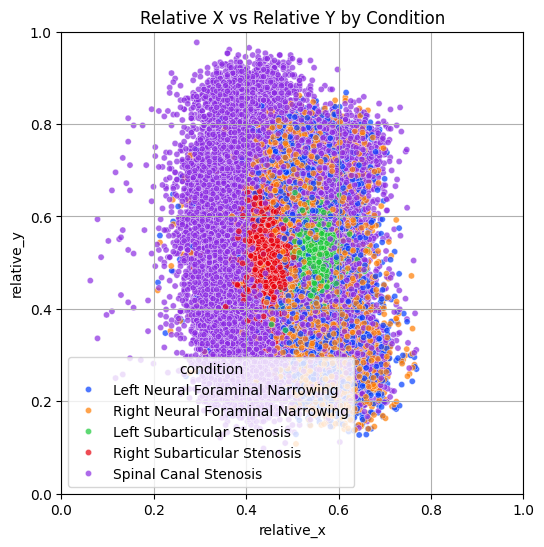

In [4]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="relative_x",
    y="relative_y",
    hue="condition",
    palette="bright",
    s = 20,
    alpha=0.7
)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Relative X vs Relative Y by Condition")
plt.grid(True)
plt.show()


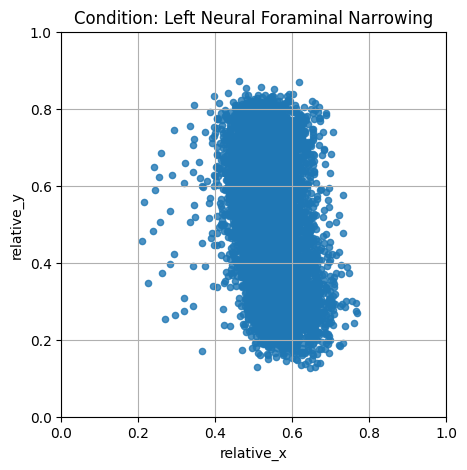

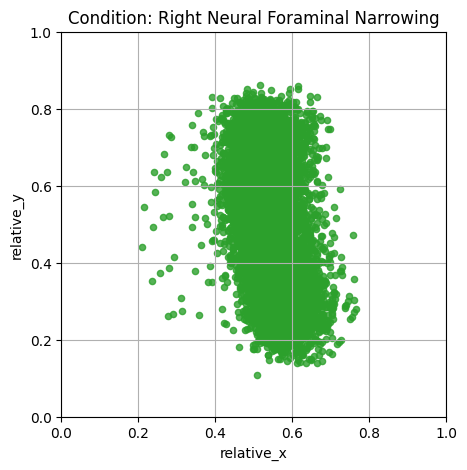

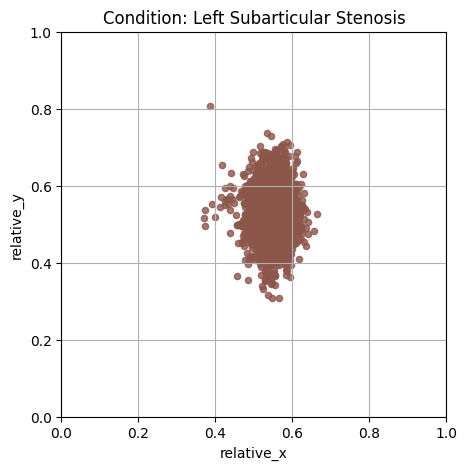

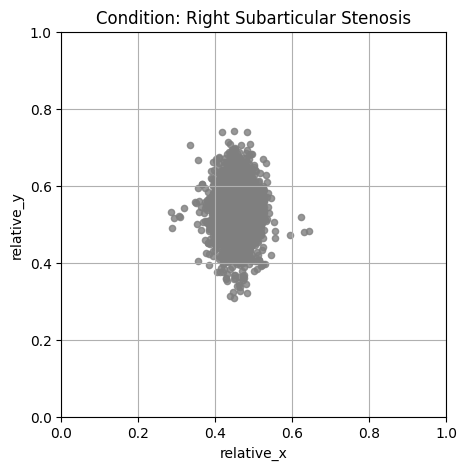

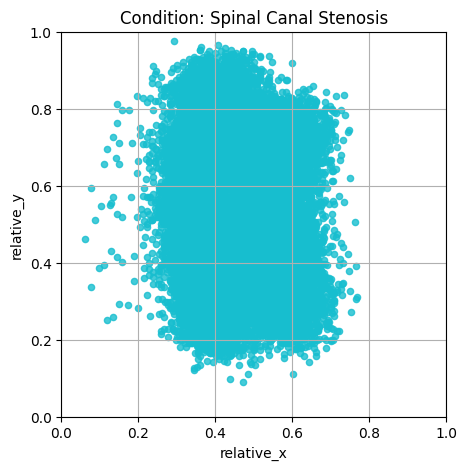

In [5]:
conditions = df["condition"].unique()

# one unique color per plot
colors = cm.tab10(np.linspace(0, 1, len(conditions)))

for cond, color in zip(conditions, colors):
    subset = df[df["condition"] == cond]

    plt.figure(figsize=(6, 5))
    plt.scatter(
        subset["relative_x"],
        subset["relative_y"],
        s=20,
        alpha=0.8,
        color=color
    )

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("relative_x")
    plt.ylabel("relative_y")
    plt.title(f"Condition: {cond}")
    plt.grid(True)
    plt.show()

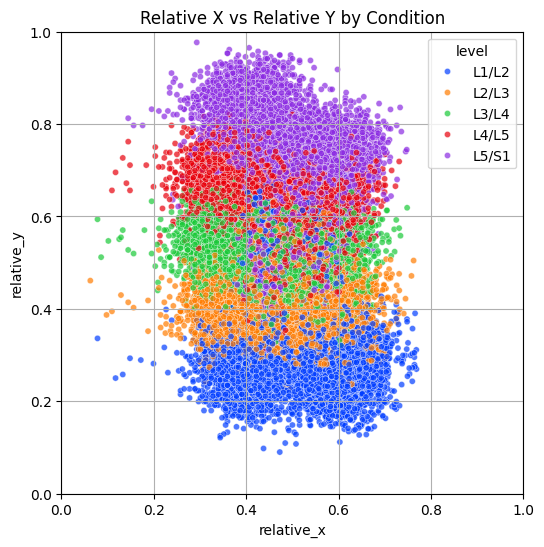

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="relative_x",
    y="relative_y",
    hue="level",
    palette="bright",
    s = 20,
    alpha=0.7
)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Relative X vs Relative Y by Condition")
plt.grid(True)
plt.show()


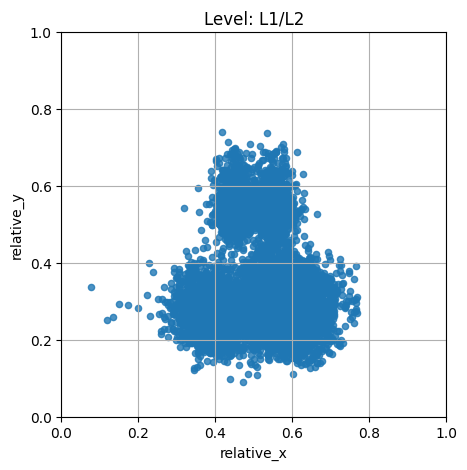

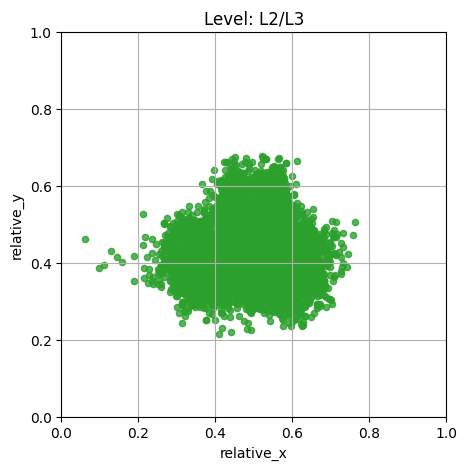

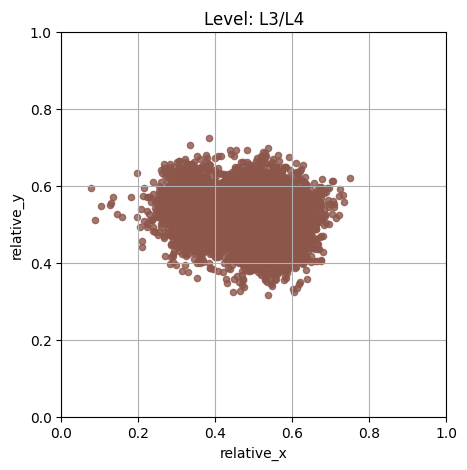

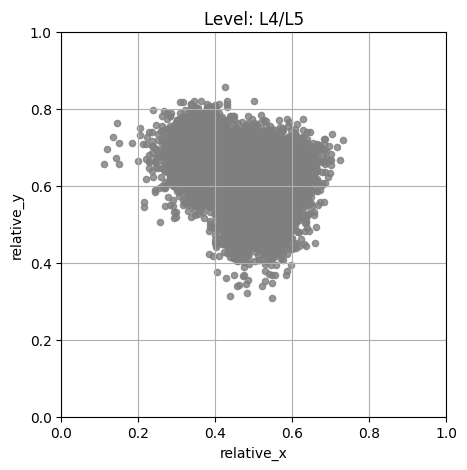

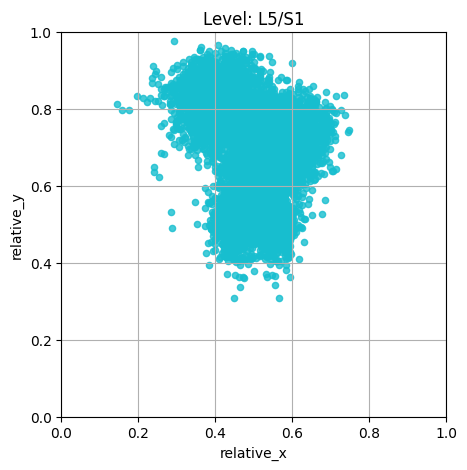

In [7]:
conditions = df["level"].unique()

# one unique color per plot
colors = cm.tab10(np.linspace(0, 1, len(conditions)))

for cond, color in zip(conditions, colors):
    subset = df[df["level"] == cond]

    plt.figure(figsize=(6, 5))
    plt.scatter(
        subset["relative_x"],
        subset["relative_y"],
        s=20,
        alpha=0.8,
        color=color
    )

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlabel("relative_x")
    plt.ylabel("relative_y")
    plt.title(f"Level: {cond}")
    plt.grid(True)
    plt.show()

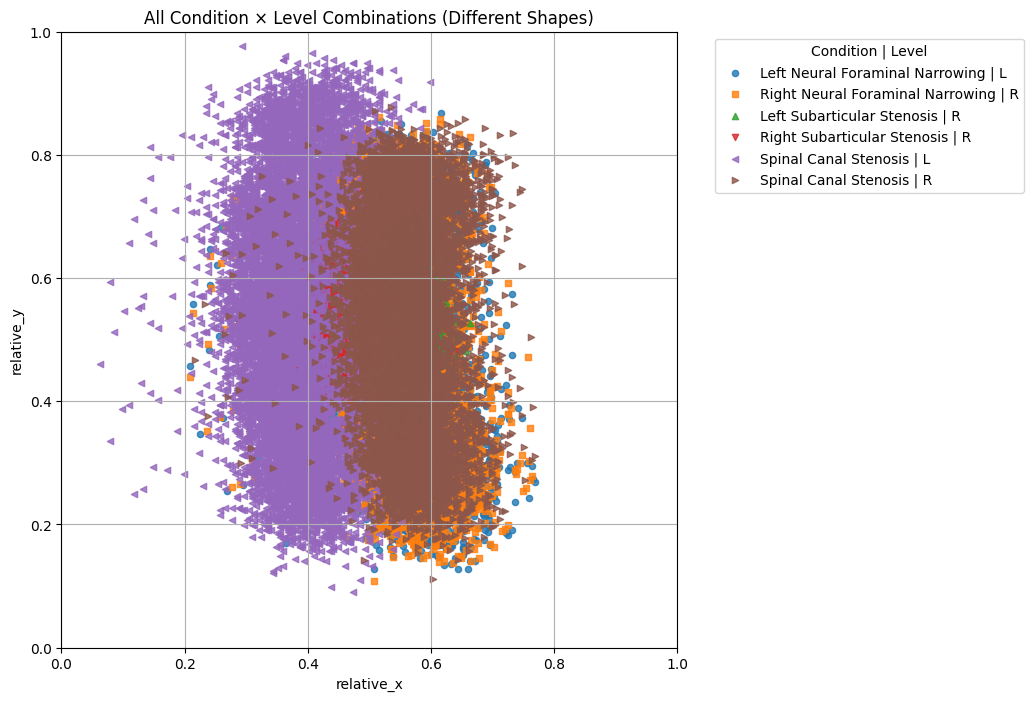

In [11]:
# Create combined category label
df["cat"] = (
    df["condition"].astype(str)
    + " | "
    + df["side"].astype(str)
)

cats = df["cat"].unique()

# List of marker shapes (extend if needed)
markers = [
    "o", "s", "^", "v", "<", ">", "P", "X",
    "D", "d", "*", "h", "H", "p"
]

# Repeat markers if there are more categories than shapes
markers = markers * (len(cats) // len(markers) + 1)

plt.figure(figsize=(10, 8))

for cat, marker in zip(cats, markers):
    subset = df[df["cat"] == cat]

    plt.scatter(
        subset["relative_x"],
        subset["relative_y"],
        s=20,
        alpha=0.8,
        marker=marker,
        label=cat
    )

# same scale for all
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("relative_x")
plt.ylabel("relative_y")
plt.title("All Condition × Level Combinations (Different Shapes)")
plt.legend(title="Condition | Level", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


In [ ]:
# We will use only CSV columns (no images):
# - Numeric: relative_x, relative_y, instance_number
# - Categorical: side, level
# - Label: condition
required_cols = ["relative_x", "relative_y", "instance_number", "side", "level", "condition"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

use_df = df[required_cols].copy()
before = len(use_df)
use_df = use_df.dropna(subset=required_cols)
after = len(use_df)
print(f"[INFO] Dropped {before - after} rows with NA in required fields.")

# Encode textual labels to integer classes
le = LabelEncoder()
y = le.fit_transform(use_df["condition"].astype(str).values)
X = use_df.drop(columns=["condition"])

print("[INFO] Classes:", list(le.classes_))


[INFO] Dropped 0 rows with NA in required fields.
[INFO] Classes: ['Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis', 'Right Neural Foraminal Narrowing', 'Right Subarticular Stenosis', 'Spinal Canal Stenosis']


In [ ]:
# First split: train vs (val+test)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
# Second split: val vs test (from the remaining 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42
)

print(f"[INFO] Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


[INFO] Shapes -> Train: (41114, 5), Val: (8810, 5), Test: (8811, 5)


In [ ]:
numeric_features = ["relative_x", "relative_y", "instance_number"]
categorical_features = ["side", "level"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


In [ ]:
# Multinomial Logistic Regression
clf = LogisticRegression(
    multi_class="multinomial",
    solver="saga",                 # good for multinomial + one-hot
    max_iter=5000,
    class_weight="balanced",       # mitigates class imbalance
    random_state=42,
    verbose=0,
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("logreg", clf),
])

# Fit
model.fit(X_train, y_train)


c:\Users\mmich\anaconda3\envs\iteso-ML\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocess', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



[VAL] Accuracy: 0.7365
[VAL] Classification report:
                                  precision    recall  f1-score   support

 Left Neural Foraminal Narrowing       0.97      0.99      0.98      1484
      Left Subarticular Stenosis       0.67      0.73      0.70      1441
Right Neural Foraminal Narrowing       0.42      0.68      0.52      1484
     Right Subarticular Stenosis       0.84      0.92      0.88      1442
           Spinal Canal Stenosis       0.95      0.56      0.70      2959

                        accuracy                           0.74      8810
                       macro avg       0.77      0.77      0.75      8810
                    weighted avg       0.80      0.74      0.74      8810

[VAL] Confusion matrix:
[[1463    0    0    0   21]
 [   0 1048  353   34    6]
 [   0  268 1011  143   62]
 [   0   31   87 1324    0]
 [  47  225  970   74 1643]]


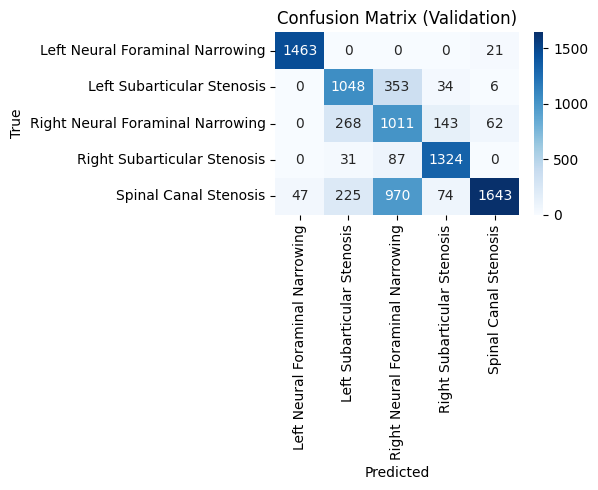


[TEST] Accuracy: 0.7554
[TEST] Classification report:
                                  precision    recall  f1-score   support

 Left Neural Foraminal Narrowing       0.97      0.99      0.98      1485
      Left Subarticular Stenosis       0.68      0.77      0.72      1441
Right Neural Foraminal Narrowing       0.45      0.72      0.56      1484
     Right Subarticular Stenosis       0.86      0.92      0.89      1442
           Spinal Canal Stenosis       0.95      0.57      0.71      2959

                        accuracy                           0.76      8811
                       macro avg       0.78      0.79      0.77      8811
                    weighted avg       0.81      0.76      0.76      8811

[TEST] Confusion matrix:
[[1472    0    0    0   13]
 [   0 1106  290   30   15]
 [   0  245 1064  118   57]
 [   0   41   78 1323    0]
 [  47  241  913   67 1691]]


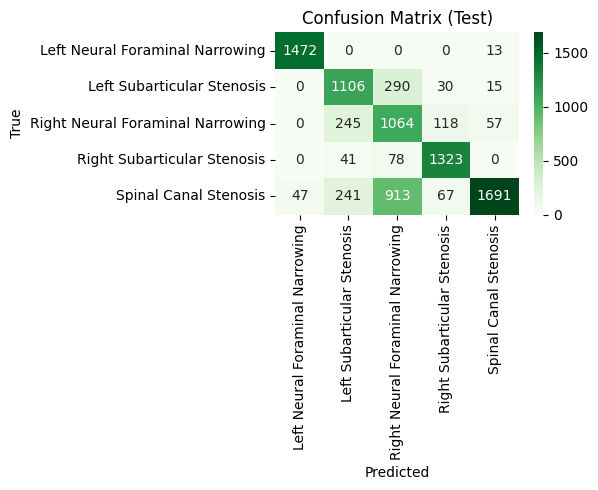

In [ ]:
# Validation
y_val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print("\n[VAL] Accuracy:", f"{val_acc:.4f}")
print("[VAL] Classification report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_, zero_division=0))
print("[VAL] Confusion matrix:")
cm_val = confusion_matrix(y_val, y_val_pred)
print(cm_val)

# Plot confusion matrix (val)
plt.figure(figsize=(6,5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Test
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("\n[TEST] Accuracy:", f"{test_acc:.4f}")
print("[TEST] Classification report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_, zero_division=0))
print("[TEST] Confusion matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

# Plot confusion matrix (test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
# Optional: persist the trained pipeline + label encoder
SAVE_MODEL = False
MODEL_OUT = "logreg_pipeline.joblib"

if SAVE_MODEL:
    import joblib
    joblib.dump({"pipeline": model, "label_encoder": le, "classes_": le.classes_}, MODEL_OUT)
    print(f"[SAVED] {MODEL_OUT}")
